<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [1]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

redpath = "/home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/"

A routine to display in image

In [2]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

<h3> Find the stars in your image</h3>

In [3]:
#filename should be the name of the combined image file (without path) that has the original header
#wcsfilename should be the name of the image that has the correct WCS header, e.g. one output
#by astrometry.net. 
def read_one_image(filename, wcsfilename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)
    wcsfile = os.path.join('{}'.format(redpath), wcsfilename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    wcshdr = fits.getheader(wcsfile)

    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(wcshdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [5]:

img_ngc7128_B, hdr_ngc7128_B, imgwcs_ngc7128_B, imgfile_ngc7128_B = read_one_image('ngc7128_B_comb.fits','wngc7128_B_comb.fits',redpath)
img_King20_V, hdr_King20_V, imgwcs_King20_V, imgfile_King20_V = read_one_image('King20_V_comb.fits','wKing20_V_comb.fits',redpath)


Reading /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/ngc7128_B_comb.fits
Reading /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/King20_V_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [6]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [9]:
#***********
bkg_V = get_sky_background(img_King20_V, verbose=True)
img_King20_V_nosky = img_King20_V - bkg_V.background

bkg_B = get_sky_background(img_ngc7128_B, verbose=True)
img_ngc7128_B_nosky = img_ngc7128_B - bkg_B.background

Sky background median = 2.633, rms = 0.062 electrons.
Sky background median = 2.296, rms = 0.057 electrons.


In [10]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

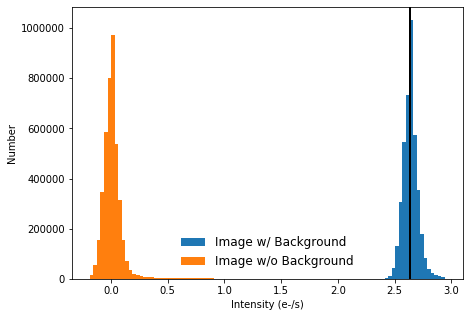

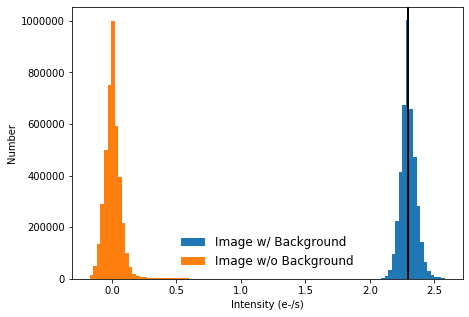

In [12]:
#***********
qa_background(img_King20_V, img_King20_V_nosky,bkg_V)
qa_background(img_ngc7128_B, img_ngc7128_B_nosky,bkg_B)

This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*
*viewer=imexam.connect()*
*viewer.load_fits('<filename>')*
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [13]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [15]:
#***********
srcs_ngc7128_B = find_stars(img_ngc7128_B_nosky, imgfile_ngc7128_B, sigma=bkg_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_B

Read 428 stars from /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/stars-ngc7128_B_comb.fits


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
171,50.465023385538,1029.0579646703886,0.3764602582795505,0.015105368056233998,-0.042203285211713376,25,0.0,910.1957247043459,1156.5022327085794,-7.657866188858424
234,963.2491906965062,1293.9710194732238,0.3996883172507363,0.015962663149320735,-0.03591971778280238,25,0.0,522.345495388082,651.6312855354504,-7.035004817733128
120,1788.350357073857,791.6072382919313,0.42858017397756726,-0.038047093729608336,-0.0007395313139146497,25,0.0,363.50867570971207,521.1380018381342,-6.792381858635799
224,1264.6039774593319,1269.575961082541,0.38596344508586916,-0.11003362044090749,-0.10115443308329898,25,0.0,334.1367081501344,434.659192461278,-6.595372172016143
424,752.474476895746,2024.6340158936082,0.4100480569163792,0.044658710182599363,-0.17909767319611652,25,0.0,238.99359444416575,353.80915004189814,-6.3719226505843505
310,978.6599513950858,1600.5009380998163,0.4411366472465794,0.03825593987586884,-0.06948994118356872,25,0.0,245.46255851523955,332.56546689194215,-6.304692876814083
329,199.80637514588116,1654.2018090275947,0.3846547208421754,0.019703471162036874,-0.12676676199064554,25,0.0,171.0536507189251,239.05123447718236,-5.946227476911188
53,450.22708783012484,407.28283472738536,0.40628840562110274,-0.0436543463886233,-0.016674129866947583,25,0.0,188.17850646469293,232.48438002424996,-5.9159844479341945
42,1266.2139995581229,338.7882680576596,0.39603345361397796,0.011721020180300655,-0.05041657295914466,25,0.0,134.42402054922314,173.77361878932672,-5.599959613195051


In [16]:
srcs_King20_V = find_stars(img_King20_V_nosky, imgfile_King20_V, sigma=bkg_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_King20_V

Read 876 stars from /home/e200o154/RFSLAB/USER_DPT/e200o154/ASTR596/Data/Reduced/20191105/stars-King20_V_comb.fits


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
502,1149.1874231065703,1298.8373575041599,0.4008561727004806,0.025745722168484038,-0.002337488567729927,25,0.0,964.8727524929322,1328.1173444678025,-7.808091120944891
381,236.31115439446103,1034.8312291486925,0.3636258378410993,0.005012950094231248,-0.29513616377857377,25,0.0,1169.1966156513747,1256.111681429836,-7.747570636067533
377,236.2130933776425,1034.1924148272615,0.4078108068502781,-0.32287719564655015,-0.46136674023917507,25,0.0,1173.898471183021,1204.7042844596303,-7.702201137218091
379,236.34228121424923,1034.4501836475984,0.46641316234352326,0.20639831942820452,0.18471236419960707,25,0.0,1132.633814350489,1183.420898768746,-7.682848086215511
265,1973.93051877368,796.1287481618039,0.4263192165715881,0.030746239095241833,0.031212726371279323,25,0.0,746.6995530787227,1163.220789358585,-7.6641553884964715
378,233.5977204974895,1034.44605015288,0.45602609182818815,0.013342205800331469,-0.1913741797198417,25,0.0,1017.6716872395102,1139.245052957778,-7.641542878460324
490,1450.515537411291,1274.3291091598905,0.40058829135484747,0.04749500244557021,-0.0036840043555300913,25,0.0,647.5575682600618,909.8091044204527,-7.397375696204559
568,1498.0496136734012,1424.5503309399771,0.4229885416695193,-0.001262492358599379,0.02558054783394441,25,0.0,604.6182158970759,900.9721473812559,-7.3867784135586545
99,1451.6357462057392,343.70115927836576,0.41419159807798256,-0.07181664016938984,-0.09477061891226103,25,0.0,538.7192394363564,751.334531896651,-7.189583374493653


<h3> Use stars from Pan-STARRS</h3>

We will be using the large survey called Pan-STARRS (https://panstarrs.stsci.edu/).  Pan-STARRS uses SDSS filters (*griz*), which are different from the "Johnson" *BVR* filters that we are using.  But there are transformation between these filters such that if we know the Pan-STARRS magnitudes of a given object, we can determine its B-V color.

This routine sends a request to a catalog server at a remote location and pulls back all the photometry

In [17]:
def get_panstarrs_catalog(imgwcs, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    

    #we limit ourselves to bright objects so that we know that they will have high Signal-to-Noise
    rmag = allcat['rMeanPSFMag']
    good = np.isfinite(rmag) * rmag < rfaint
    cat = allcat[good]
    print('Keeping {}/{} Pan-STARRS sources with rmag< {}.'.format(len(cat), len(allcat),rfaint))
    
    #make B and V-band magnitudes using the transformations published in Tonry et al. (2012)
    #https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T/abstract
    cat['B'] = 0.213 + 0.587 * (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['gMeanPSFMag'] 
    cat['V'] = 0.006 + 0.474 *  (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['rMeanPSFMag'] 
    
    return cat

In [18]:
%time refcat_King20_V = get_panstarrs_catalog(imgwcs_King20_V, radius=0.2)
refcat_King20_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.34789,58.48745


Keeping 637/646 Pan-STARRS sources with rmag< 17.
CPU times: user 301 ms, sys: 82.8 ms, total: 384 ms
Wall time: 9.96 s


objID,raMean,decMean,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,B,V
int64,float64,float64,float64,float64,float64,float64,float64,float64
177973533643142604,353.36438085,58.30983231,12.566200256347656,12.007800102233887,13.251099586486816,12.253600120544434,13.106981146812439,12.278481775283813
178253534222408649,353.42222936,58.54832542,13.094300270080566,12.312999725341797,13.089300155639648,12.481800079345703,13.765923689842225,12.689336183547974
178063533638825273,353.3639764,58.38714689,12.656000137329102,12.395000457763672,12.265000343322754,12.16100025177002,13.02220694923401,12.524714305877685
178193533621090461,353.36215886,58.49157593,13.093000411987305,12.541000366210938,12.26200008392334,12.09000015258789,13.630024438858031,12.808648387908935
178003535709165660,353.57091598,58.33742606,12.979000091552734,12.571000099182129,12.34000015258789,12.159000396728516,13.43149608707428,12.770392095565796
178243534353808280,353.43544285,58.53951268,13.38700008392334,12.699000358581543,12.326000213623047,12.074000358581543,14.003855922698975,13.031112228393555
177943533354839104,353.33555251,58.2904111,14.216699600219727,12.987000465393066,12.402000427246094,12.01200008392334,15.151532992362975,13.575877855300904
178283534833775064,353.48342907,58.57027888,13.446000099182129,13.022000312805176,12.788000106811523,12.595000267028809,13.9078879737854,13.228976211547852
178203532822397719,353.28226479,58.50580757,13.437000274658203,13.062000274658203,12.831000328063965,12.675000190734863,13.870125274658204,13.245750274658203


In [20]:
%time refcat_ngc7128_B = get_panstarrs_catalog(imgwcs_ngc7128_B, radius=0.2)
refcat_ngc7128_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=353.31246,58.48701
Keeping 625/634 Pan-STARRS sources with rmag< 17.
CPU times: user 28.5 ms, sys: 6.91 ms, total: 35.4 ms
Wall time: 2.71 s


objID,raMean,decMean,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,B,V
int64,float64,float64,float64,float64,float64,float64,float64,float64
177973533643142604,353.36438085,58.30983231,12.566200256347656,12.007800102233887,13.251099586486816,12.253600120544434,13.106981146812439,12.278481775283813
178253534222408649,353.42222936,58.54832542,13.094300270080566,12.312999725341797,13.089300155639648,12.481800079345703,13.765923689842225,12.689336183547974
178063533638825273,353.3639764,58.38714689,12.656000137329102,12.395000457763672,12.265000343322754,12.16100025177002,13.02220694923401,12.524714305877685
178193533621090461,353.36215886,58.49157593,13.093000411987305,12.541000366210938,12.26200008392334,12.09000015258789,13.630024438858031,12.808648387908935
178243534353808280,353.43544285,58.53951268,13.38700008392334,12.699000358581543,12.326000213623047,12.074000358581543,14.003855922698975,13.031112228393555
177943533354839104,353.33555251,58.2904111,14.216699600219727,12.987000465393066,12.402000427246094,12.01200008392334,15.151532992362975,13.575877855300904
178283534833775064,353.48342907,58.57027888,13.446000099182129,13.022000312805176,12.788000106811523,12.595000267028809,13.9078879737854,13.228976211547852
178203532822397719,353.28226479,58.50580757,13.437000274658203,13.062000274658203,12.831000328063965,12.675000190734863,13.870125274658204,13.245750274658203
178343535329972488,353.53306465,58.61813399,13.969900131225586,13.088000297546387,12.800000190734863,12.607000350952148,14.700575333595276,13.512020818710328


We need to match the Pan-STARRS catalog against ours.  First we need to compute the nearest Pan-STARRS star to each of ours and look at the distribution of distances to find the optimal match.

In [21]:
def sep_check(imgwcs,srcs,refcat):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    #this makes an instance of a SkyCoord class containing the RAs and Decs from Pan-STARRS objects
    refcoord = SkyCoord(ra=refcat['raMean']*u.deg, dec=refcat['decMean']*u.deg)
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars = imgwcs.all_pix2world(srcs['xcentroid']+1, srcs['ycentroid']+1, 1)
    #this does the same from our targets 
    coord = SkyCoord(ra=radec_stars[0]*u.deg, dec=radec_stars[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord.match_to_catalog_sky(refcoord)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    return refcoord, coord

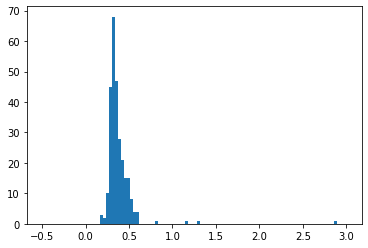

In [22]:
refcoord_King20_V, coord_King20_V = sep_check(imgwcs_King20_V,srcs_King20_V,refcat_King20_V)

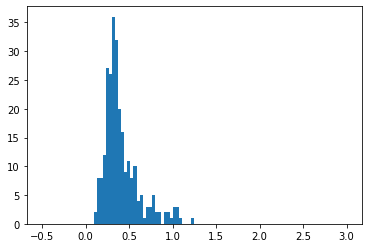

In [23]:
refcoord_ngc7128_B, coord_ngc7128_B = sep_check(imgwcs_ngc7128_B,srcs_ngc7128_B,refcat_ngc7128_B)

It looks like the optimal match is less than 1.0 arcsec.  The following routine matches to within this tolerance

In [24]:
#take two lists of coordinates 
def match_src_ref(refcoord, coord, srcs, img, radasec = 1.0):
    rad = radasec * u.arcsec

    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_ref, indx, d2d, _ = coord.search_around_sky(refcoord, rad)
    nmatch = len(indx_ref)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs), rad))
    display_image(img, srcs=srcs[indx], calibrated=True)
    return indx, indx_ref

In [25]:
indx_King20_V, indx_ref_King20_V = match_src_ref(refcoord_King20_V, coord_King20_V, srcs_King20_V, img_King20_V)
indx_ngc7128_B, indx_ref_ngc7128_B = match_src_ref(refcoord_ngc7128_B, coord_ngc7128_B, srcs_ngc7128_B, img_ngc7128_B)

NameError: name 'u' is not defined

Now let's calculate the zeropoints for each image.  To compare our objects to those from Pan-STARRS we will need to correct for the effects of airmass.

We start by specifying the atmospheric extinction coefficient for each object.  This says for a typical atmosphere, how much the magnitude changes for an increase in airmass of 1.  We could have measured this using mutliple standard stars but will just assume a cannonical value for now.

In [ ]:
def zp_meas(srcs, refcat, indx, indx_ref, hdr):
    kext = {'B': 0.4, 'V': 0.2}
    import numpy.ma as ma

    #this consists of the instrumental magnitude, which is the magnitude, including an airmass correction
    #but without a true zeropoint.  The second term says how the magnitude 
    #m(inst) = -2.5 * log(flux) - (sec z) * k
    instmag = srcs['mag'][indx].data - hdr['AIRMASS'] * kext[hdr['FILTER']]

    #the Pan-STARRS magnitudes for the same objects, as indicated using the indx_ref array
    psmag = refcat[hdr['FILTER']][indx_ref].data

    #calculate the median zeropoint defined as
    #psmag = -2.5 * log(flux) - (sec z) * k + ZP = m(inst) + ZP
    medzp = np.median(psmag - instmag)
    print(hdr['FILTER'],'zeropoint = ', medzp)
    print('Airmass in {} was {}'.format(hdr['FILTER'], hdr['AIRMASS']))
    return medzp

In [ ]:
ZPV = zp_meas(srcs_ngc7296_V,refcat_ngc7296_V, indx_ngc7296_V, indx_ref_ngc7296_V,hdr_ngc7296_V)
ZPB = zp_meas(srcs_ngc7296_B,refcat_ngc7296_B, indx_ngc7296_B, indx_ref_ngc7296_B,hdr_ngc7296_B)

Now match the B and V-band catalogs together for this cluster, apply the zeropoints, and plot a CMD!

In [ ]:
def make_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, ZPB, ZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + ZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + ZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    #print(magB-magV)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(magB-magV, magV, 'ro',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show


In [ ]:
make_CMD(img_ngc7296_B, imgwcs_ngc7296_B, srcs_ngc7296_B,imgwcs_ngc7296_V, srcs_ngc7296_V, hdr_ngc7296_B, hdr_ngc7296_V, ZPB, ZPV, radasec = 1.0)